# Method 9 - Rest Ideas After 20

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 20].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

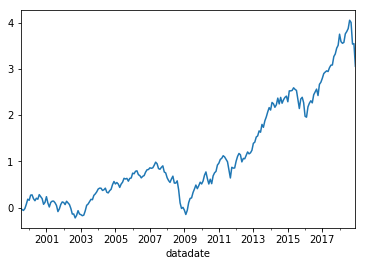

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.181657
2000-12-31   -0.058182
2001-12-31    0.007962
2002-12-31   -0.232233
2003-12-31    0.555832
2004-12-31    0.166789
2005-12-31    0.048608
2006-12-31    0.112025
2007-12-31   -0.040511
2008-12-31   -0.425625
2009-12-31    0.541675
2010-12-31    0.239317
2011-12-31   -0.032946
2012-12-31    0.205764
2013-12-31    0.412138
2014-12-31    0.078861
2015-12-31   -0.041874
2016-12-31    0.135557
2017-12-31    0.215026
2018-12-31   -0.100420
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1835.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.26e-172
Time:                        20:39:44   Log-Likelihood:                 760.10
No. Observations:                 234   AIC:                            -1510.
Df Residuals:                     229   BIC:                            -1493.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      4.532      0.000       0.002       0.004
mktrf          1.0310      0.018     58.189      0.000       0.996       1.066
me             0.3005      0.021     14.582      0.000       0.260       0.341
ia             0.0650      0.031      2.075      0.039       0.003       0.127
roe           -0.2436      0.027     -9.086      0.000      -0.296      -0.191
==============================================================================
Omnibus:                       52.219   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              243.094
Skew:                           0.775   Prob(JB):                     1.63e-53
Kurtosis:                       7.747   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1372.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.12e-158
Time:                        20:39:44   Log-Likelihood:                 760.10
No. Observations:                 234   AIC:                            -1510.
Df Residuals:                     229   BIC:                            -1493.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.471      0.001       0.001       0.005
mktrf          1.0310      0.020     50.370      0.000       0.991       1.071
me             0.3005      0.037      8.069      0.000       0.228       0.374
ia             0.0650      0.053      1.235      0.217      -0.038       0.168
roe           -0.2436      0.045     -5.374      0.000      -0.332      -0.155
==============================================================================
Omnibus:                       52.219   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              243.094
Skew:                           0.775   Prob(JB):                     1.63e-53
Kurtosis:                       7.747   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1717.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.02e-169
Time:                        20:39:44   Log-Likelihood:                 760.10
No. Observations:                 234   AIC:                            -1510.
Df Residuals:                     229   BIC:                            -1493.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.103      0.002       0.001       0.005
mktrf          1.0310      0.021     50.164      0.000       0.991       1.071
me             0.3005      0.038      7.987      0.000       0.227       0.374
ia             0.0650      0.044      1.485      0.138      -0.021       0.151
roe           -0.2436      0.048     -5.105      0.000      -0.337      -0.150
==============================================================================
Omnibus:                       52.219   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              243.094
Skew:                           0.775   Prob(JB):                     1.63e-53
Kurtosis:                       7.747   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     1159.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.04e-160
Time:                        20:39:44   Log-Likelihood:                 733.89
No. Observations:                 234   AIC:                            -1456.
Df Residuals:                     228   BIC:                            -1435.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      3.021      0.003       0.001       0.004
mktrf          1.0774      0.020     54.134      0.000       1.038       1.117
smb            0.3530      0.026     13.441      0.000       0.301       0.405
hml            0.0543      0.031      1.754      0.081      -0.007       0.115
rmw           -0.1402      0.035     -4.004      0.000      -0.209      -0.071
cma            0.0252      0.044      0.566      0.572      -0.062       0.113
==============================================================================
Omnibus:                       79.568   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              399.029
Skew:                           1.250   Prob(JB):                     2.25e-87
Kurtosis:                       8.888   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     1067.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.22e-156
Time:                        20:39:44   Log-Likelihood:                 733.89
No. Observations:                 234   AIC:                            -1456.
Df Residuals:                     228   BIC:                            -1435.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.567      0.010       0.001       0.004
mktrf          1.0774      0.018     60.487      0.000       1.042       1.112
smb            0.3530      0.038      9.201      0.000       0.278       0.428
hml            0.0543      0.058      0.941      0.347      -0.059       0.167
rmw           -0.1402      0.050     -2.819      0.005      -0.238      -0.043
cma            0.0252      0.069      0.365      0.715      -0.110       0.161
==============================================================================
Omnibus:                       79.568   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              399.029
Skew:                           1.250   Prob(JB):                     2.25e-87
Kurtosis:                       8.888   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     1242.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.52e-163
Time:                        20:39:44   Log-Likelihood:                 733.89
No. Observations:                 234   AIC:                            -1456.
Df Residuals:                     228   BIC:                            -1435.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.232      0.026       0.000       0.004
mktrf          1.0774      0.018     60.285      0.000       1.042       1.112
smb            0.3530      0.032     10.897      0.000       0.289       0.416
hml            0.0543      0.052      1.041      0.298      -0.048       0.157
rmw           -0.1402      0.056     -2.515      0.012      -0.249      -0.031
cma            0.0252      0.069      0.365      0.715      -0.110       0.160
==============================================================================
Omnibus:                       79.568   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              399.029
Skew:                           1.250   Prob(JB):                     2.25e-87
Kurtosis:                       8.888   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1802.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.31e-172
Time:                        20:39:44   Log-Likelihood:                 758.06
No. Observations:                 234   AIC:                            -1506.
Df Residuals:                     229   BIC:                            -1489.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      3.740      0.000       0.001       0.004
mktrf          1.0493      0.016     63.759      0.000       1.017       1.082
smb            0.4237      0.021     20.628      0.000       0.383       0.464
hml            0.0637      0.020      3.119      0.002       0.023       0.104
umd           -0.1263      0.013     -9.433      0.000      -0.153      -0.100
==============================================================================
Omnibus:                       22.461   Durbin-Watson:                   1.696
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.978
Skew:                           0.335   Prob(JB):                     7.77e-15
Kurtosis:                       5.493   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1539.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.64e-164
Time:                        20:39:44   Log-Likelihood:                 758.06
No. Observations:                 234   AIC:                            -1506.
Df Residuals:                     229   BIC:                            -1489.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.716      0.007       0.001       0.004
mktrf          1.0493      0.018     58.883      0.000       1.014       1.084
smb            0.4237      0.025     16.667      0.000       0.374       0.474
hml            0.0637      0.045      1.418      0.156      -0.024       0.152
umd           -0.1263      0.021     -5.967      0.000      -0.168      -0.085
==============================================================================
Omnibus:                       22.461   Durbin-Watson:                   1.696
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.978
Skew:                           0.335   Prob(JB):                     7.77e-15
Kurtosis:                       5.493   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1806.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.52e-172
Time:                        20:39:44   Log-Likelihood:                 758.06
No. Observations:                 234   AIC:                            -1506.
Df Residuals:                     229   BIC:                            -1489.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.347      0.019       0.000       0.004
mktrf          1.0493      0.015     69.158      0.000       1.020       1.079
smb            0.4237      0.025     17.267      0.000       0.376       0.472
hml            0.0637      0.046      1.380      0.167      -0.027       0.154
umd           -0.1263      0.019     -6.755      0.000      -0.163      -0.090
==============================================================================
Omnibus:                       22.461   Durbin-Watson:                   1.696
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.978
Skew:                           0.335   Prob(JB):                     7.77e-15
Kurtosis:                       5.493   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     785.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.76e-82
Time:                        20:39:44   Log-Likelihood:                 365.38
No. Observations:                 120   AIC:                            -720.8
Df Residuals:                     115   BIC:                            -706.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.001      4.068      0.000       0.002       0.007
mktrf          1.0276      0.030     33.881      0.000       0.967       1.088
me             0.2663      0.030      8.889      0.000       0.207       0.326
ia             0.0984      0.047      2.099      0.038       0.006       0.191
roe           -0.2726      0.042     -6.567      0.000      -0.355      -0.190
==============================================================================
Omnibus:                       20.166   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.475
Skew:                           0.654   Prob(JB):                     3.63e-10
Kurtosis:                       5.642   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     873.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.09e-85
Time:                        20:39:44   Log-Likelihood:                 365.38
No. Observations:                 120   AIC:                            -720.8
Df Residuals:                     115   BIC:                            -706.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.001      3.119      0.002       0.002       0.007
mktrf          1.0276      0.030     34.759      0.000       0.970       1.086
me             0.2663      0.042      6.306      0.000       0.184       0.349
ia             0.0984      0.067      1.475      0.140      -0.032       0.229
roe           -0.2726      0.054     -5.006      0.000      -0.379      -0.166
==============================================================================
Omnibus:                       20.166   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.475
Skew:                           0.654   Prob(JB):                     3.63e-10
Kurtosis:                       5.642   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     1316.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.44e-95
Time:                        20:39:44   Log-Likelihood:                 365.38
No. Observations:                 120   AIC:                            -720.8
Df Residuals:                     115   BIC:                            -706.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.002      2.702      0.007       0.001       0.008
mktrf          1.0276      0.028     36.091      0.000       0.972       1.083
me             0.2663      0.044      6.003      0.000       0.179       0.353
ia             0.0984      0.053      1.850      0.064      -0.006       0.203
roe           -0.2726      0.056     -4.864      0.000      -0.383      -0.163
==============================================================================
Omnibus:                       20.166   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.475
Skew:                           0.654   Prob(JB):                     3.63e-10
Kurtosis:                       5.642   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     491.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.18e-75
Time:                        20:39:44   Log-Likelihood:                 351.75
No. Observations:                 120   AIC:                            -691.5
Df Residuals:                     114   BIC:                            -674.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.001      3.250      0.002       0.002       0.007
mktrf          1.1377      0.036     31.618      0.000       1.066       1.209
smb            0.3507      0.041      8.604      0.000       0.270       0.431
hml            0.0171      0.050      0.343      0.732      -0.082       0.116
rmw           -0.0912      0.059     -1.549      0.124      -0.208       0.025
cma            0.0915      0.065      1.417      0.159      -0.036       0.219
==============================================================================
Omnibus:                       31.538   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.682
Skew:                           0.947   Prob(JB):                     1.50e-19
Kurtosis:                       6.708   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     649.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.54e-82
Time:                        20:39:44   Log-Likelihood:                 351.75
No. Observations:                 120   AIC:                            -691.5
Df Residuals:                     114   BIC:                            -674.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.001      2.869      0.004       0.001       0.007
mktrf          1.1377      0.028     41.289      0.000       1.084       1.192
smb            0.3507      0.054      6.540      0.000       0.246       0.456
hml            0.0171      0.086      0.199      0.842      -0.151       0.186
rmw           -0.0912      0.068     -1.349      0.177      -0.224       0.041
cma            0.0915      0.082      1.115      0.265      -0.069       0.252
==============================================================================
Omnibus:                       31.538   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.682
Skew:                           0.947   Prob(JB):                     1.50e-19
Kurtosis:                       6.708   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     1116.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.86e-95
Time:                        20:39:44   Log-Likelihood:                 351.75
No. Observations:                 120   AIC:                            -691.5
Df Residuals:                     114   BIC:                            -674.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.002      2.499      0.012       0.001       0.008
mktrf          1.1377      0.023     48.690      0.000       1.092       1.184
smb            0.3507      0.046      7.671      0.000       0.261       0.440
hml            0.0171      0.080      0.214      0.831      -0.140       0.175
rmw           -0.0912      0.073     -1.255      0.209      -0.234       0.051
cma            0.0915      0.080      1.140      0.254      -0.066       0.249
==============================================================================
Omnibus:                       31.538   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.682
Skew:                           0.947   Prob(JB):                     1.50e-19
Kurtosis:                       6.708   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     827.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.03e-83
Time:                        20:39:44   Log-Likelihood:                 368.34
No. Observations:                 120   AIC:                            -726.7
Df Residuals:                     115   BIC:                            -712.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.001      4.116      0.000       0.002       0.007
mktrf          1.0638      0.026     40.811      0.000       1.012       1.115
smb            0.4268      0.030     14.381      0.000       0.368       0.486
hml            0.0756      0.030      2.544      0.012       0.017       0.134
umd           -0.1343      0.018     -7.328      0.000      -0.171      -0.098
==============================================================================
Omnibus:                        6.659   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.036   Jarque-Bera (JB):               11.053
Skew:                           0.110   Prob(JB):                      0.00398
Kurtosis:                       4.471   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     828.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.11e-84
Time:                        20:39:44   Log-Likelihood:                 368.34
No. Observations:                 120   AIC:                            -726.7
Df Residuals:                     115   BIC:                            -712.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.001      3.425      0.001       0.002       0.007
mktrf          1.0638      0.028     38.642      0.000       1.010       1.118
smb            0.4268      0.034     12.581      0.000       0.360       0.493
hml            0.0756      0.063      1.199      0.230      -0.048       0.199
umd           -0.1343      0.024     -5.666      0.000      -0.181      -0.088
==============================================================================
Omnibus:                        6.659   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.036   Jarque-Bera (JB):               11.053
Skew:                           0.110   Prob(JB):                      0.00398
Kurtosis:                       4.471   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     958.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.74e-87
Time:                        20:39:44   Log-Likelihood:                 368.34
No. Observations:                 120   AIC:                            -726.7
Df Residuals:                     115   BIC:                            -712.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.001      2.967      0.003       0.002       0.007
mktrf          1.0638      0.023     46.150      0.000       1.019       1.109
smb            0.4268      0.035     12.159      0.000       0.358       0.496
hml            0.0756      0.066      1.143      0.253      -0.054       0.205
umd           -0.1343      0.021     -6.545      0.000      -0.175      -0.094
==============================================================================
Omnibus:                        6.659   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.036   Jarque-Bera (JB):               11.053
Skew:                           0.110   Prob(JB):                      0.00398
Kurtosis:                       4.471   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     1735.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.14e-97
Time:                        20:39:44   Log-Likelihood:                 430.10
No. Observations:                 114   AIC:                            -850.2
Df Residuals:                     109   BIC:                            -836.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.518      0.013       0.000       0.003
mktrf          1.0303      0.017     61.602      0.000       0.997       1.063
me             0.3739      0.026     14.479      0.000       0.323       0.425
ia            -0.0313      0.036     -0.874      0.384      -0.102       0.040
roe           -0.2099      0.031     -6.671      0.000      -0.272      -0.148
==============================================================================
Omnibus:                        4.353   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.113   Jarque-Bera (JB):                3.751
Skew:                          -0.371   Prob(JB):                        0.153
Kurtosis:                       3.488   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     3192.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.29e-112
Time:                        20:39:44   Log-Likelihood:                 430.10
No. Observations:                 114   AIC:                            -850.2
Df Residuals:                     109   BIC:                            -836.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.837      0.005       0.000       0.002
mktrf          1.0303      0.015     67.195      0.000       1.000       1.060
me             0.3739      0.021     17.847      0.000       0.333       0.415
ia            -0.0313      0.036     -0.871      0.384      -0.102       0.039
roe           -0.2099      0.024     -8.909      0.000      -0.256      -0.164
==============================================================================
Omnibus:                        4.353   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.113   Jarque-Bera (JB):                3.751
Skew:                          -0.371   Prob(JB):                        0.153
Kurtosis:                       3.488   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     4816.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.35e-121
Time:                        20:39:44   Log-Likelihood:                 430.10
No. Observations:                 114   AIC:                            -850.2
Df Residuals:                     109   BIC:                            -836.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.000      3.075      0.002       0.001       0.002
mktrf          1.0303      0.015     70.302      0.000       1.002       1.059
me             0.3739      0.019     19.487      0.000       0.336       0.411
ia            -0.0313      0.040     -0.787      0.431      -0.109       0.047
roe           -0.2099      0.022     -9.717      0.000      -0.252      -0.168
==============================================================================
Omnibus:                        4.353   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.113   Jarque-Bera (JB):                3.751
Skew:                          -0.371   Prob(JB):                        0.153
Kurtosis:                       3.488   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     1419.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.48e-97
Time:                        20:39:44   Log-Likelihood:                 431.86
No. Observations:                 114   AIC:                            -851.7
Df Residuals:                     108   BIC:                            -835.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.751      0.454      -0.001       0.002
mktrf          1.0414      0.016     66.007      0.000       1.010       1.073
smb            0.3485      0.026     13.608      0.000       0.298       0.399
hml            0.0578      0.033      1.771      0.079      -0.007       0.123
rmw           -0.2442      0.040     -6.106      0.000      -0.324      -0.165
cma           -0.0873      0.051     -1.719      0.088      -0.188       0.013
==============================================================================
Omnibus:                        3.787   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.151   Jarque-Bera (JB):                3.219
Skew:                          -0.318   Prob(JB):                        0.200
Kurtosis:                       3.522   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     1834.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.12e-102
Time:                        20:39:44   Log-Likelihood:                 431.86
No. Observations:                 114   AIC:                            -851.7
Df Residuals:                     108   BIC:                            -835.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.709      0.478      -0.001       0.002
mktrf          1.0414      0.013     80.563      0.000       1.016       1.067
smb            0.3485      0.021     16.476      0.000       0.307       0.390
hml            0.0578      0.039      1.496      0.135      -0.018       0.134
rmw           -0.2442      0.036     -6.868      0.000      -0.314      -0.175
cma           -0.0873      0.042     -2.067      0.039      -0.170      -0.005
==============================================================================
Omnibus:                        3.787   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.151   Jarque-Bera (JB):                3.219
Skew:                          -0.318   Prob(JB):                        0.200
Kurtosis:                       3.522   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     2231.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.15e-107
Time:                        20:39:44   Log-Likelihood:                 431.86
No. Observations:                 114   AIC:                            -851.7
Df Residuals:                     108   BIC:                            -835.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.629      0.529      -0.001       0.002
mktrf          1.0414      0.012     90.421      0.000       1.019       1.064
smb            0.3485      0.019     17.933      0.000       0.310       0.387
hml            0.0578      0.041      1.406      0.160      -0.023       0.138
rmw           -0.2442      0.033     -7.460      0.000      -0.308      -0.180
cma           -0.0873      0.043     -2.049      0.040      -0.171      -0.004
==============================================================================
Omnibus:                        3.787   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.151   Jarque-Bera (JB):                3.219
Skew:                          -0.318   Prob(JB):                        0.200
Kurtosis:                       3.522   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1393.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.42e-92
Time:                        20:39:44   Log-Likelihood:                 417.82
No. Observations:                 114   AIC:                            -825.6
Df Residuals:                     109   BIC:                            -812.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         7.9e-05      0.001      0.125      0.900      -0.001       0.001
mktrf          1.0531      0.018     59.662      0.000       1.018       1.088
smb            0.4078      0.028     14.817      0.000       0.353       0.462
hml            0.0458      0.028      1.615      0.109      -0.010       0.102
umd           -0.0768      0.021     -3.592      0.000      -0.119      -0.034
==============================================================================
Omnibus:                        4.529   Durbin-Watson:                   1.717
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                4.120
Skew:                          -0.332   Prob(JB):                        0.127
Kurtosis:                       3.654   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1536.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.65e-95
Time:                        20:39:44   Log-Likelihood:                 417.82
No. Observations:                 114   AIC:                            -825.6
Df Residuals:                     109   BIC:                            -812.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         7.9e-05      0.001      0.126      0.900      -0.001       0.001
mktrf          1.0531      0.016     64.030      0.000       1.021       1.085
smb            0.4078      0.026     15.920      0.000       0.358       0.458
hml            0.0458      0.039      1.176      0.239      -0.030       0.122
umd           -0.0768      0.020     -3.780      0.000      -0.117      -0.037
==============================================================================
Omnibus:                        4.529   Durbin-Watson:                   1.717
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                4.120
Skew:                          -0.332   Prob(JB):                        0.127
Kurtosis:                       3.654   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2945.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.88e-110
Time:                        20:39:44   Log-Likelihood:                 417.82
No. Observations:                 114   AIC:                            -825.6
Df Residuals:                     109   BIC:                            -812.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         7.9e-05      0.001      0.119      0.905      -0.001       0.001
mktrf          1.0531      0.015     70.423      0.000       1.024       1.082
smb            0.4078      0.019     20.981      0.000       0.370       0.446
hml            0.0458      0.041      1.110      0.267      -0.035       0.127
umd           -0.0768      0.018     -4.341      0.000      -0.111      -0.042
==============================================================================
Omnibus:                        4.529   Durbin-Watson:                   1.717
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                4.120
Skew:                          -0.332   Prob(JB):                        0.127
Kurtosis:                       3.654   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""